In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def generate_lifetime_decay_photon_simulation(num_photons, lifetime, time_range=(0, 12.5), time_bins=256, 
                                             background=0, instrument_response=None):
    """
    Simulate a fluorescence lifetime decay curve using direct photon arrival time simulation.
    
    Parameters:
    -----------
    num_photons : int
        Total number of photons to simulate
    lifetime : float
        Fluorescence lifetime (in nanoseconds)
    time_range : tuple
        (min_time, max_time) in nanoseconds
    time_bins : int
        Number of time bins to use
    background : float
        Expected background counts per bin
    instrument_response : array or None
        Instrument response function (probability distribution)
        
    Returns:
    --------
    times : numpy array
        Time points (center of bins) of the simulation
    counts : numpy array
        Photon counts at each time point
    """
    min_time, max_time = time_range
    
    # Simulate individual photon arrival times using exponential distribution
    # Scale parameter in numpy's exponential distribution is the mean (lifetime)
    photon_arrival_times = np.random.exponential(scale=lifetime, size=num_photons)
    print(f"photon count arrial ========{photon_arrival_times.shape}")
    # Filter out photons outside the time range
    photon_arrival_times = photon_arrival_times[photon_arrival_times <= max_time]
    
    # Create the binned histogram (the decay curve)
    bin_edges = np.linspace(min_time, max_time, time_bins + 1)
    counts, _ = np.histogram(photon_arrival_times, bins=bin_edges)
    
    # Calculate the center of each bin for the time axis
    times = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Apply instrument response function if provided
    if instrument_response is not None:
        # Ensure IRF is properly sized and normalized
        if len(instrument_response) != time_bins:
            irf_resized = np.interp(np.linspace(0, 1, time_bins), 
                                   np.linspace(0, 1, len(instrument_response)), 
                                   instrument_response)
            irf_normalized = irf_resized / np.sum(irf_resized)
        else:
            irf_normalized = instrument_response / np.sum(instrument_response)
            
        # Convolve with the IRF
        counts = np.convolve(counts, irf_normalized, mode='same')
    
    # Add random background counts (Poisson distributed)
    if background > 0:
        bg_counts = np.random.poisson(background, size=time_bins)
        counts = counts + bg_counts
    
    return times, counts

def exponential_model(t, a, tau, c):
    """
    Single exponential decay model with background.
    
    Parameters:
    t : time
    a : amplitude
    tau : lifetime
    c : background constant
    """
    return a * np.exp(-t / tau) + c

def fit_lifetime_decay(times, counts, initial_guess=None):
    """
    Fit the lifetime decay curve with a single exponential model.
    
    Parameters:
    -----------
    times : numpy array
        Time points
    counts : numpy array
        Count data
    initial_guess : tuple or None
        Initial parameters (amplitude, lifetime, background)
        
    Returns:
    --------
    params : tuple
        Fitted parameters (amplitude, lifetime, background)
    covariance : array
        Covariance matrix of the fit
    """
    if initial_guess is None:
        # Estimate initial parameters
        background = np.min(counts)
        amplitude = np.max(counts) - background
        lifetime = times[len(times)//3] - times[0]  # Rough estimate
        initial_guess = (amplitude, lifetime, background)
    
    try:
        params, covariance = curve_fit(exponential_model, times, counts, p0=initial_guess)
        return params, covariance
    except:
        print("Fitting failed. Try adjusting initial parameters.")
        return initial_guess, None

def plot_lifetime_decay(times, counts, fitted_params=None, log_scale=True, 
                        residuals=True, title="Fluorescence Lifetime Decay"):
    """
    Plot the lifetime decay curve and optionally the fit.
    
    Parameters:
    -----------
    times : numpy array
        Time points
    counts : numpy array
        Count data
    fitted_params : tuple or None
        Fitted parameters (amplitude, lifetime, background)
    log_scale : bool
        Whether to use log scale for y-axis
    residuals : bool
        Whether to plot residuals (only if fitted_params is provided)
    title : str
        Plot title
    """
    if residuals and fitted_params is not None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), 
                                       gridspec_kw={'height_ratios': [3, 1]})
    else:
        fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot data
    ax1.plot(times, counts, 'b.', alpha=0.5, label='Data')
    
    # Plot fit if provided
    if fitted_params is not None:
        amplitude, lifetime, background = fitted_params
        fitted_curve = exponential_model(times, amplitude, lifetime, background)
        ax1.plot(times, fitted_curve, 'r-', label=f'Fit: τ = {lifetime:.3f} ns')
        
        # Add fit information to the plot
        text_info = f"Fitted τ = {lifetime:.3f} ns\nAmplitude = {amplitude:.1f}\nBackground = {background:.1f}"
        ax1.text(0.98, 0.98, text_info, transform=ax1.transAxes, 
                 ha='right', va='top', bbox=dict(facecolor='white', alpha=0.8))
    
    ax1.set_xlabel('Time (ns)')
    ax1.set_ylabel('Counts')
    ax1.set_title(title)
    ax1.legend()
    
    if log_scale:
        ax1.set_yscale('log')
    
    # Plot residuals if requested
    if residuals and fitted_params is not None:
        fitted_curve = exponential_model(times, *fitted_params)
        res = counts - fitted_curve
        ax2.plot(times, res, 'g.', alpha=0.5)
        ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax2.set_xlabel('Time (ns)')
        ax2.set_ylabel('Residuals')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def simulate_multi_exponential_decay(num_photons, lifetimes, amplitudes, time_range=(0, 10), time_bins=1000, background=0):
    """
    Simulate a multi-exponential fluorescence decay curve.
    
    Parameters:
    -----------
    num_photons : int
        Total number of photons to simulate
    lifetimes : list of float
        Lifetimes in nanoseconds for each component
    amplitudes : list of float
        Relative amplitudes for each component (will be normalized)
    time_range : tuple
        (min_time, max_time) in nanoseconds
    time_bins : int
        Number of time bins to use
    background : float
        Expected background counts per bin
        
    Returns:
    --------
    times : numpy array
        Time points of the simulation
    counts : numpy array
        Photon counts at each time point
    """
    min_time, max_time = time_range
    
    # Normalize amplitudes to sum to 1
    norm_amplitudes = np.array(amplitudes) / np.sum(amplitudes)
    
    # Determine number of photons for each component
    component_photons = np.random.multinomial(num_photons, norm_amplitudes)
    
    # Initialize empty array for all photon arrival times
    all_photon_times = np.array([])
    
    # Generate photons for each lifetime component
    for i, (lifetime, n_photons) in enumerate(zip(lifetimes, component_photons)):
        if n_photons > 0:
            # Generate arrival times for this component
            photon_times = np.random.exponential(scale=lifetime, size=n_photons)
            all_photon_times = np.append(all_photon_times, photon_times)
        print(f"len all photons:{len(all_photon_times)}")
    # Filter out photons outside the time range
    all_photon_times = all_photon_times[all_photon_times <= max_time]
    
    # Create the binned histogram
    bin_edges = np.linspace(min_time, max_time, time_bins + 1)
    counts, _ = np.histogram(all_photon_times, bins=bin_edges)
    
    # Calculate bin centers for time axis
    times = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Add random background counts if specified
    if background > 0:
        bg_counts = np.random.poisson(background, size=time_bins)
        counts = counts + bg_counts
    
    return times, counts

# Example usage
if __name__ == "__main__":
    # Parameters
    num_photons = 10000
    true_lifetime = 1.2  # nanoseconds
    time_range = (0, 12.5)  # nanoseconds
    time_bins = 256
    background_level = 0 # average background counts per bin
    
    # Simulate decay curve using direct photon simulation
    times, counts = generate_lifetime_decay_photon_simulation(
        num_photons=num_photons,
        lifetime=true_lifetime,
        time_range=time_range,
        time_bins=time_bins,
        background=background_level
    )
    
    # Fit the data
    fitted_params, covariance = fit_lifetime_decay(times, counts)
    
    if covariance is not None:
        # Calculate uncertainty
        perr = np.sqrt(np.diag(covariance))
        fitted_lifetime = fitted_params[1]
        lifetime_error = perr[1]
        cv_percent = (lifetime_error / fitted_lifetime) * 100
        print(f"True lifetime: {true_lifetime} ns")
        print(f"Fitted lifetime: {fitted_params[1]:.3f} ± {perr[1]:.3f} ns")
        print(f"Total photons detected: {np.sum(counts)}")
        print(f"Coefficient of variation: {cv_percent:.2f}%")
    else:
        print(f"True lifetime: {true_lifetime} ns")
        print(f"Fitting failed to converge")
    '''
    # Plot the results
    plot_lifetime_decay(times, counts, fitted_params, log_scale=True, residuals=True,
                       title=f"Fluorescence Decay (τ = {true_lifetime} ns, {num_photons} photons)")
    
    # Example of multi-exponential decay simulation
    print("\nSimulating multi-exponential decay...")
    times_multi, counts_multi = simulate_multi_exponential_decay(
        num_photons=num_photons,
        lifetimes=[1.2, 3.5],  # Two lifetime components
        amplitudes=[0.7, 0.3],  # 70% first component, 30% second component
        time_range=time_range,
        time_bins=time_bins,
        background=background_level
    )
    
    plt.figure(figsize=(10, 6))
    plt.plot(times_multi, counts_multi, 'b.', alpha=0.5)
    plt.yscale('log')
    plt.xlabel('Time (ns)')
    plt.ylabel('Counts')
    plt.title('Multi-exponential Decay (τ₁=1.2ns, τ₂=3.5ns)')
    plt.tight_layout()
    plt.show()
    '''

    export_decay_data_as_3d_tiff(times, counts, f"E:\\Projects\\Fluorescein_Quenching\\python_simulations\\SINGLE_t1_{true_lifetime}_my_decay_data_4.tiff", box_size=(40, 40))

photon count arrial ========(10000,)
True lifetime: 1.2 ns
Fitted lifetime: 1.180 ± 0.010 ns
Total photons detected: 9999
Coefficient of variation: 0.86%
(256, 40, 40)
Decay data exported as 3D TIFF with dimensions (256, 256, 256): E:\Projects\Fluorescein_Quenching\python_simulations\SINGLE_t1_1.2_my_decay_data_4.tiff
Raw decay data saved as CSV: E:\Projects\Fluorescein_Quenching\python_simulations\SINGLE_t1_1.2_my_decay_data_4.csv


In [26]:
bincalc = np.rint(np.linspace(2,256,15)).astype(int)
print(bincalc)

[  2  20  38  56  75  93 111 129 147 165 183 202 220 238 256]


photon count arrial ========(10000,)
Fitting failed. Try adjusting initial parameters.
True lifetime: 1.0 ns
Fitting failed to converge
photon count arrial ========(10000,)
True lifetime: 1.0 ns
Fitted lifetime: 0.995 ± inf ns
Total photons detected: 10000 why not 10000???
Coefficient of variation: inf%
photon count arrial ========(10000,)
True lifetime: 1.0 ns
Fitted lifetime: 0.996 ± 0.003 ns
Total photons detected: 10000 why not 10000???
Coefficient of variation: 0.33%
photon count arrial ========(10000,)
True lifetime: 1.0 ns
Fitted lifetime: 1.031 ± 0.006 ns
Total photons detected: 10000 why not 10000???
Coefficient of variation: 0.57%
photon count arrial ========(10000,)
True lifetime: 1.0 ns
Fitted lifetime: 1.012 ± 0.005 ns
Total photons detected: 10000 why not 10000???
Coefficient of variation: 0.48%
photon count arrial ========(10000,)
True lifetime: 1.0 ns
Fitted lifetime: 0.982 ± 0.005 ns
Total photons detected: 10000 why not 10000???
Coefficient of variation: 0.50%
photon 

C:\Users\hwilson23\AppData\Local\Temp\ipykernel_42356\3340264906.py:109: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(exponential_model, times, counts, p0=initial_guess)


photon count arrial ========(10000,)
True lifetime: 2.333333333333333 ns
Fitted lifetime: 2.311 ± inf ns
Total photons detected: 9958 why not 10000???
Coefficient of variation: inf%
photon count arrial ========(10000,)
True lifetime: 2.333333333333333 ns
Fitted lifetime: 2.357 ± 0.008 ns
Total photons detected: 9955 why not 10000???
Coefficient of variation: 0.35%
photon count arrial ========(10000,)
True lifetime: 2.333333333333333 ns
Fitted lifetime: 2.341 ± 0.016 ns
Total photons detected: 9948 why not 10000???
Coefficient of variation: 0.69%
photon count arrial ========(10000,)
True lifetime: 2.333333333333333 ns
Fitted lifetime: 2.294 ± 0.032 ns
Total photons detected: 9962 why not 10000???
Coefficient of variation: 1.40%
photon count arrial ========(10000,)
True lifetime: 2.333333333333333 ns
Fitted lifetime: 2.385 ± 0.044 ns
Total photons detected: 9948 why not 10000???
Coefficient of variation: 1.83%
photon count arrial ========(10000,)
True lifetime: 2.333333333333333 ns
Fitte

C:\Users\hwilson23\AppData\Local\Temp\ipykernel_42356\3340264906.py:79: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-t / tau) + c


True lifetime: 3.6666666666666665 ns
Fitted lifetime: 3.901 ± 0.117 ns
Total photons detected: 9635 why not 10000???
Coefficient of variation: 2.99%
photon count arrial ========(10000,)
True lifetime: 3.6666666666666665 ns
Fitted lifetime: 3.781 ± 0.112 ns
Total photons detected: 9669 why not 10000???
Coefficient of variation: 2.95%
photon count arrial ========(10000,)
True lifetime: 3.6666666666666665 ns
Fitted lifetime: 3.647 ± 0.103 ns
Total photons detected: 9691 why not 10000???
Coefficient of variation: 2.83%
photon count arrial ========(10000,)
True lifetime: 3.6666666666666665 ns
Fitted lifetime: 3.679 ± 0.123 ns
Total photons detected: 9626 why not 10000???
Coefficient of variation: 3.34%
photon count arrial ========(10000,)
True lifetime: 3.6666666666666665 ns
Fitted lifetime: 3.769 ± 0.122 ns
Total photons detected: 9658 why not 10000???
Coefficient of variation: 3.24%
photon count arrial ========(10000,)
True lifetime: 3.6666666666666665 ns
Fitted lifetime: 3.646 ± 0.112 ns

C:\Users\hwilson23\AppData\Local\Temp\ipykernel_42356\3340264906.py:79: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-t / tau) + c


photon count arrial ========(10000,)
True lifetime: 4.555555555555555 ns
Fitted lifetime: 4.821 ± 0.257 ns
Total photons detected: 9356 why not 10000???
Coefficient of variation: 5.33%
photon count arrial ========(10000,)
True lifetime: 4.555555555555555 ns
Fitted lifetime: 4.985 ± 0.177 ns
Total photons detected: 9373 why not 10000???
Coefficient of variation: 3.56%
photon count arrial ========(10000,)
True lifetime: 4.555555555555555 ns
Fitted lifetime: 4.703 ± 0.179 ns
Total photons detected: 9367 why not 10000???
Coefficient of variation: 3.81%
photon count arrial ========(10000,)
True lifetime: 4.555555555555555 ns
Fitted lifetime: 4.634 ± 0.254 ns
Total photons detected: 9354 why not 10000???
Coefficient of variation: 5.49%
photon count arrial ========(10000,)
True lifetime: 4.555555555555555 ns
Fitted lifetime: 4.275 ± 0.182 ns
Total photons detected: 9348 why not 10000???
Coefficient of variation: 4.25%
photon count arrial ========(10000,)
True lifetime: 4.555555555555555 ns
Fi

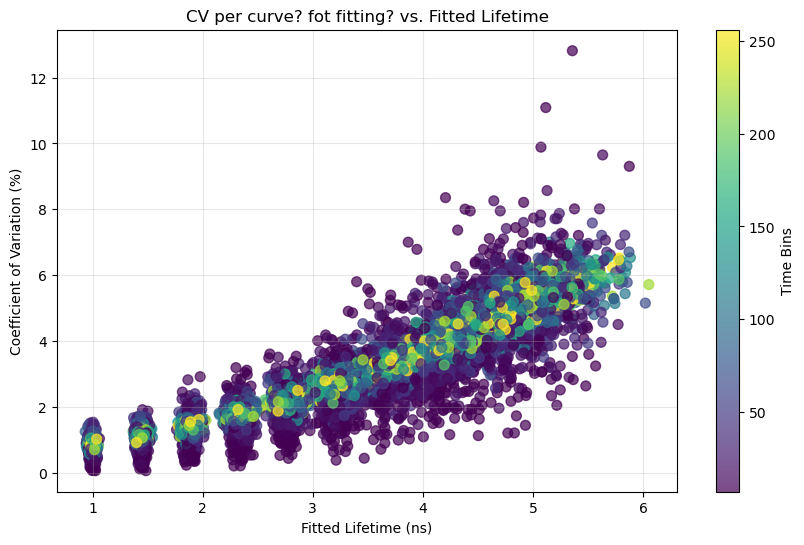

140


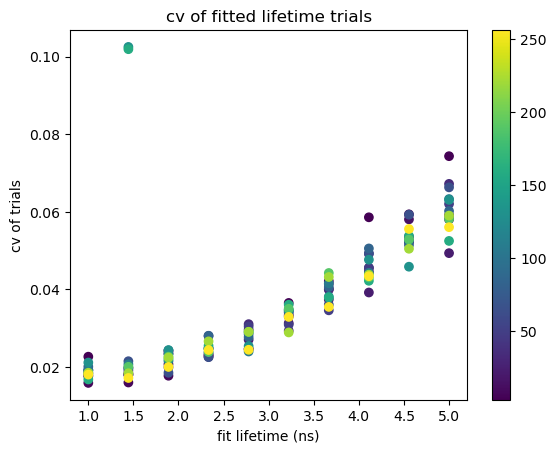

In [27]:
# Example usage

datastore = []

#bincalc = np.rint(np.linspace(2,256,15)).astype(int)
bincalc = np.rint(2 + (256-2) * (np.linspace(0, 1, 15)**2)).astype(int)
trials = np.linspace(1,5,100)
taurepeats = np.linspace(1,5,10)
for c in trials:
    for t in taurepeats:
        all_data = []
        
        for b in bincalc:
            
            if __name__ == "__main__":
                # Parameters
                num_photons = 10000
                true_lifetime = t  # nanoseconds
                time_range = (0, 12.5)  # nanoseconds
                time_bins = b
                background_level = 0  # average background counts per bin
                
                # Simulate decay curve using direct photon simulation
                times, counts = generate_lifetime_decay_photon_simulation(
                    num_photons=num_photons,
                    lifetime=true_lifetime,
                    time_range=time_range,
                    time_bins=time_bins,
                    background=background_level
                )
                
                # Fit the data
                fitted_params, covariance = fit_lifetime_decay(times, counts)
                
                if covariance is not None:
                    # Calculate uncertainty
                    perr = np.sqrt(np.diag(covariance))
                    fitted_lifetime = fitted_params[1]
                    lifetime_error = perr[1]
                    cv_percent = (lifetime_error / fitted_lifetime) * 100
                    print(f"True lifetime: {true_lifetime} ns")
                    print(f"Fitted lifetime: {fitted_params[1]:.3f} ± {perr[1]:.3f} ns")
                    print(f"Total photons detected: {np.sum(counts)} why not 10000???")
                    print(f"Coefficient of variation: {cv_percent:.2f}%")
                    datastore.append({"true lifetime": true_lifetime, "fitted lifetime": fitted_lifetime, "time_bins": time_bins, "cv_percent": cv_percent})
                else:
                    print(f"True lifetime: {true_lifetime} ns")
                    print(f"Fitting failed to converge")
                
                all_data.append({
                    'times': times,
                    'counts': counts,
                    'fitted_params': fitted_params,
                    'bin_size': time_bins
                })

                # Plot the results
                #plot_lifetime_decay(times, counts, fitted_params, log_scale=True, residuals=True,
                                #title=f"Fluorescence Decay (τ = {true_lifetime} ns, {num_photons} photons, time bin {time_bins})")
        '''    
        plt.figure(figsize=(12, 8))

        # Create a color cycle for different curves
        colors = plt.cm.viridis(np.linspace(0, 1, len(all_data)))

        for i, data in enumerate(all_data):
            times = data['times']
            counts = data['counts']
            fitted_params = data['fitted_params']
            bin_size = data['bin_size']
            
            # Plot data points
            plt.semilogy(times, counts, 'o', label=f'Bin size: {bin_size}', 
                            color=colors[i], markersize=4, alpha=0.7)
            
            # Plot fitted curve if fit was successful
            if fitted_params is not None:
                fitted_curve = exponential_model(times, *fitted_params)
                plt.semilogy(times, fitted_curve, '-', linewidth=2, 
                                color=colors[i], alpha=0.9)

        plt.xlabel('Time (ns)')
        plt.ylabel('Counts (log scale)')
        plt.title(f"Fluorescence Decay (τ = {true_lifetime} ns, {num_photons} photons)")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
        '''

# Extract the data for plotting
fitted_lifetimes = [item["fitted lifetime"] for item in datastore]
cv_percents = [item["cv_percent"] for item in datastore]
bin_sizes = [item["time_bins"] for item in datastore]

from collections import defaultdict
data_by_true_lifetime = defaultdict(list)
for item in datastore:
    true_lifetime = item["true lifetime"]
    fitted = item["fitted lifetime"]
    bin = item["time_bins"]
    data_by_true_lifetime[true_lifetime,bin].append(fitted)

true = []
cvbytrue = []
binbytrue = []

#not sure if this really does what i think it does
#goal to calculate cv for batch of true lifetimes separated by the bin value
numcvcount = 0
for key, fitted in data_by_true_lifetime.items():
    true_lifetime,bin = key
    mean_fittedbytrue = np.mean(fitted)
    std_fittedbytrue = np.std(fitted)
    cvbytruecalc = (std_fittedbytrue / mean_fittedbytrue)
    #print(len(fitted))
    true.append(true_lifetime)
    cvbytrue.append(cvbytruecalc)
    binbytrue.append(bin)

    numcvcount += 1


plt.figure(figsize=(10, 6))
scatter = plt.scatter(fitted_lifetimes, cv_percents, 
                     c=bin_sizes,        # Color points by bin size
                     s=50,              # Base point size
                     alpha=0.7,         # Add transparency
                     cmap='viridis')    # Color map

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Time Bins')

plt.xlabel('Fitted Lifetime (ns)')
plt.ylabel('Coefficient of Variation (%)')
plt.title('CV per curve? fot fitting? vs. Fitted Lifetime')
plt.grid(True, alpha=0.3)
plt.show()

plt.scatter(true,cvbytrue, c=binbytrue)
cbar.set_label('time bins')
plt.colorbar()
plt.xlabel('fit lifetime (ns)')
plt.ylabel('cv of trials')
plt.title('cv of fitted lifetime trials')
plt.show


print(numcvcount)


Analyzing multi-exponential decay...
len all photons:7004
len all photons:10000
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP MODEL
USING MULTI EXP M

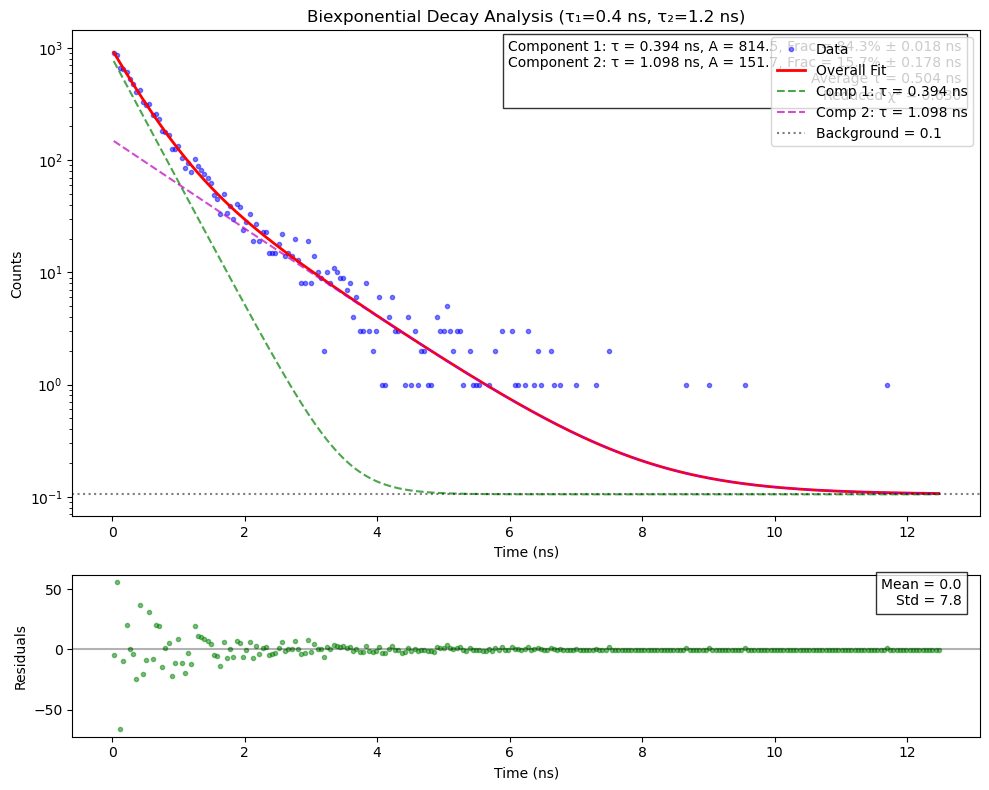

In [28]:

def multi_exponential_model(t, *params):
    """
    Multi-exponential decay model with background.
    
    Parameters:
    t : time
    params : tuple containing:
        - amplitudes (a1, a2, ..., an)
        - lifetimes (tau1, tau2, ..., taun)
        - background constant c
    
    Returns:
    --------
    Decay curve values at times t
    """
    n_components = (len(params) - 1) // 2
    amplitudes = params[:n_components]
    lifetimes = params[n_components:2*n_components]
    background = params[-1]
    
    result = background
    for i in range(n_components):
        result += amplitudes[i] * np.exp(-t / lifetimes[i])
    print('USING MULTI EXP MODEL')
    return result

def fit_multi_exponential_decay(times, counts, n_components, initial_guess=None):
    """
    Fit the lifetime decay curve with a multi-exponential model.
    
    Parameters:
    -----------
    times : numpy array
        Time points
    counts : numpy array
        Count data
    n_components : int
        Number of exponential components to fit
    initial_guess : tuple or None
        Initial parameters (a1, a2, ..., an, tau1, tau2, ..., taun, background)
        
    Returns:
    --------
    params : tuple
        Fitted parameters (a1, a2, ..., an, tau1, tau2, ..., taun, background)
    covariance : array
        Covariance matrix of the fit
    """
    if initial_guess is None:
        # Estimate initial parameters
        background = np.min(counts)
        amplitude_total = np.max(counts) - background
        
        # Distribute amplitude evenly initially
        amplitudes = [amplitude_total / n_components] * n_components
        
        # Estimate lifetimes logarithmically distributed between short and long times
        min_lifetime = times[1] - times[0]  # Approximately one time bin
        max_lifetime = (times[-1] - times[0]) / 3  # Rough estimate
        
        lifetimes = np.logspace(np.log10(min_lifetime), np.log10(max_lifetime), n_components)
        
        # Combine all initial parameters
        initial_guess = tuple(amplitudes) + tuple(lifetimes) + (background,)
    
    try:
        params, covariance = curve_fit(multi_exponential_model, times, counts, p0=initial_guess)
        return params, covariance
    except Exception as e:
        print(f"Fitting failed. Error: {e}")
        print("Try adjusting initial parameters.")
        return initial_guess, None

def analyze_multi_exponential_decay(times, counts, n_components, initial_guess=None):
    """
    Analyze multi-exponential decay data and return fitted parameters and derived values.
    
    Parameters:
    -----------
    times : numpy array
        Time points
    counts : numpy array
        Count data
    n_components : int
        Number of exponential components to fit
    initial_guess : tuple or None
        Initial parameters (a1, a2, ..., an, tau1, tau2, ..., taun, background)
        
    Returns:
    --------
    result_dict : dict
        Dictionary containing fitted parameters and derived values:
        - 'fitted_params': tuple of all fitted parameters
        - 'amplitudes': numpy array of fitted amplitudes
        - 'lifetimes': numpy array of fitted lifetimes
        - 'background': fitted background value
        - 'fractional_amplitudes': relative contribution of each component
        - 'average_lifetime': amplitude-weighted average lifetime
        - 'errors': standard errors of parameters (if fit was successful)
        - 'fitted_curve': array of fitted values at the same time points
    """
    # Fit the data
    fitted_params, covariance = fit_multi_exponential_decay(times, counts, n_components, initial_guess)
    
    # Extract the fitted parameters
    amplitudes = fitted_params[:n_components]
    lifetimes = fitted_params[n_components:2*n_components]
    background = fitted_params[-1]
    
    # Calculate the fitted curve ###########
    fitted_curve = multi_exponential_model(times, *fitted_params)
    print(fitted_curve)
    # Calculate derived parameters
    total_amplitude = np.sum(amplitudes)
    fractional_amplitudes = amplitudes / total_amplitude
    
    # Calculate amplitude-weighted average lifetime
    average_lifetime = np.sum(fractional_amplitudes * lifetimes)
    
    # Calculate intensity fractions (fractional contributions to total intensity)
    intensity_values = amplitudes * lifetimes
    intensity_fractions = intensity_values / np.sum(intensity_values)
    
    # Create result dictionary
    result = {
        'fitted_params': fitted_params,
        'amplitudes': amplitudes,
        'lifetimes': lifetimes,
        'background': background,
        'fractional_amplitudes': fractional_amplitudes,
        'intensity_fractions': intensity_fractions,
        'average_lifetime': average_lifetime,
        'fitted_curve': fitted_curve
    }
    
    # Add error estimates if the fit was successful
    if covariance is not None:
        perr = np.sqrt(np.diag(covariance))
        result['errors'] = perr
        
        # Split errors into components
        result['amplitude_errors'] = perr[:n_components]
        result['lifetime_errors'] = perr[n_components:2*n_components]
        result['background_error'] = perr[-1]
        
        # Calculate goodness of fit metrics
        residuals = counts - fitted_curve
        chi_squared = np.sum((residuals ** 2) / (counts + 1))  # Add 1 to avoid division by zero
        reduced_chi_squared = chi_squared / (len(counts) - len(fitted_params))
        result['chi_squared'] = chi_squared
        result['reduced_chi_squared'] = reduced_chi_squared
    
    return result

def plot_multi_exponential_decay(times, counts, analysis_result, log_scale=True, 
                              residuals=True, title="Multi-exponential Fluorescence Decay"):
    """
    Plot the multi-exponential lifetime decay curve with fit and components.
    
    Parameters:
    -----------
    times : numpy array
        Time points
    counts : numpy array
        Count data
    analysis_result : dict
        The result dictionary from analyze_multi_exponential_decay
    log_scale : bool
        Whether to use log scale for y-axis
    residuals : bool
        Whether to plot residuals
    title : str
        Plot title
    
    Returns:
    --------
    fig : matplotlib figure
        The figure object containing the plot
    """
    # Extract parameters from analysis result
    fitted_curve = analysis_result['fitted_curve']
    amplitudes = analysis_result['amplitudes']
    lifetimes = analysis_result['lifetimes']
    background = analysis_result['background']
    n_components = len(lifetimes)
    
    # Create appropriate subplot layout
    if residuals:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), 
                                     gridspec_kw={'height_ratios': [3, 1]})
    else:
        fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot data
    ax1.plot(times, counts, 'b.', alpha=0.5, label='Data')
    
    # Plot overall fit
    ax1.plot(times, fitted_curve, 'r-', linewidth=2, label='Overall Fit')
    
    # Plot individual components
    colors = ['g', 'm', 'c', 'y', 'orange']  # Colors for different components
    for i in range(n_components):
        component = amplitudes[i] * np.exp(-times / lifetimes[i]) + background
        ax1.plot(times, component, '--', color=colors[i % len(colors)], alpha=0.7,
                label=f'Comp {i+1}: τ = {lifetimes[i]:.3f} ns')
    
    # Add background line
    ax1.axhline(y=background, color='k', linestyle=':', alpha=0.5, label=f'Background = {background:.1f}')
    
    # Build information text for the plot
    text_lines = [f"Component {i+1}: τ = {lifetimes[i]:.3f} ns, A = {amplitudes[i]:.1f}, Frac = {analysis_result['fractional_amplitudes'][i]*100:.1f}%" 
                  for i in range(n_components)]
    
    if 'errors' in analysis_result:
        lifetime_errors = analysis_result['lifetime_errors']
        for i in range(n_components):
            text_lines[i] += f" ± {lifetime_errors[i]:.3f} ns"
            
    text_lines.append(f"Average τ = {analysis_result['average_lifetime']:.3f} ns")
    if 'reduced_chi_squared' in analysis_result:
        text_lines.append(f"Reduced χ² = {analysis_result['reduced_chi_squared']:.3f}")
    
    ax1.text(0.98, 0.98, '\n'.join(text_lines), transform=ax1.transAxes, 
           ha='right', va='top', bbox=dict(facecolor='white', alpha=0.8))
    
    ax1.set_xlabel('Time (ns)')
    ax1.set_ylabel('Counts')
    ax1.set_title(title)
    ax1.legend(loc='upper right')
    
    if log_scale:
        ax1.set_yscale('log')
    
    # Plot residuals if requested
    if residuals:
        res = counts - fitted_curve
        ax2.plot(times, res, 'g.', alpha=0.5)
        ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax2.set_xlabel('Time (ns)')
        ax2.set_ylabel('Residuals')
        
        # Add residual statistics
        if 'errors' in analysis_result:
            res_mean = np.mean(res)
            res_std = np.std(res)
            ax2.text(0.98, 0.98, f"Mean = {res_mean:.1f}\nStd = {res_std:.1f}", 
                   transform=ax2.transAxes, ha='right', va='top', 
                   bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    return fig

# Modify the main part of the code to include biexponential analysis
if __name__ == "__main__":
    # Original single-exponential example (keep this for comparison)
    # [existing code...]
    
    # Add new multi-exponential analysis for the existing biexponential example
    print("\nAnalyzing multi-exponential decay...")
    
    # Create a new biexponential decay example with known parameters
    num_photons = 10000  # More photons for better statistics
    true_lifetimes = [0.4, 1.2]  # Two lifetime components (in ns)
    true_amplitudes = [0.7, 0.3]  # Relative amplitudes (70% and 30%)
    time_range = (0, 12.5)  # nanoseconds
    time_bins = 256
    background_level = 0  # Add some background for realism
    
    # Simulate the biexponential decay
    times_multi, counts_multi = simulate_multi_exponential_decay(
        num_photons=num_photons,
        lifetimes=true_lifetimes,
        amplitudes=true_amplitudes,
        time_range=time_range,
        time_bins=time_bins,
        background=background_level
    )
    
    # Set initial guess based on true values (in practice, you'd estimate these)
    initial_guess = (
        num_photons * 0.3 * 0.1,  # Amplitude 1 (scaled down)
        num_photons * 0.7 * 0.1,  # Amplitude 2 (scaled down)
        0.3,  # Lifetime 1 (ns)
        1.1,  # Lifetime 2 (ns)
        background_level  # Background
    )
    
    # Analyze the biexponential decay
    analysis_result = analyze_multi_exponential_decay(
        times_multi, 
        counts_multi, 
        n_components=2, 
        initial_guess=initial_guess
    )
    
    # Display the results
    print("\nBiexponential Decay Analysis Results:")
    print(f"True lifetimes: {true_lifetimes} ns")
    print(f"Fitted lifetimes: {analysis_result['lifetimes']} ns")
    if 'lifetime_errors' in analysis_result:
        print(f"Lifetime errors: {analysis_result['lifetime_errors']} ns")
    
    print(f"True amplitude fractions: {true_amplitudes}")
    print(f"Fitted amplitude fractions: {analysis_result['fractional_amplitudes']}")
    print(f"Intensity fractions: {analysis_result['intensity_fractions']}")
    print(f"Average lifetime: {analysis_result['average_lifetime']:.3f} ns")
    print(f"Total photons detected: {np.sum(counts_multi)} multi")
  
    
    if 'reduced_chi_squared' in analysis_result:
        print(f"Reduced chi-squared: {analysis_result['reduced_chi_squared']:.3f}")
    
    # Plot the results
    fig = plot_multi_exponential_decay(
        times_multi, 
        counts_multi, 
        analysis_result,
        log_scale=True, 
        residuals=True,
        title=f"Biexponential Decay Analysis (τ₁={true_lifetimes[0]} ns, τ₂={true_lifetimes[1]} ns)"
    )
    '''
    # Try fitting with different number of components
    print("\nTrying to fit with 3 components (when true model is 2 components)...")
    analysis_result_3comp = analyze_multi_exponential_decay(
        times_multi, 
        counts_multi, 
        n_components=3
    )
    
    # Plot the 3-component fit for comparison
    fig3 = plot_multi_exponential_decay(
        times_multi, 
        counts_multi, 
        analysis_result_3comp,
        log_scale=True, 
        residuals=True,
        title="Testing 3-Component Fit (when true model is 2 components)"
    )
    '''
    plt.show()



In [29]:
import json
import numpy as np

# Helper class to handle NumPy arrays in JSON serialization
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.number):
            return float(obj)
        return json.JSONEncoder.default(self, obj)

def export_decay_data_as_3d_tiff(times, counts, filename="decay_data_3d.tiff",
                               normalize=False, time_dimension_first=True, box_size=(40, 40)):
    """
    Export fluorescence lifetime decay data as a 3D TIFF image stack with the same decay 
    curve repeated across a 2D image of specified size.
   
    Parameters:
    -----------
    times : numpy array
        Time points of the decay curve (nanoseconds)
    counts : numpy array
        Count data of the decay curve
    filename : str
        Output filename for the 3D TIFF image
    normalize : bool
        Whether to normalize the counts to 0-65535 range (16-bit)
    time_dimension_first : bool
        If True, time is the first dimension (Z), otherwise it's the last
    box_size : tuple
        Size of the 2D image (width, height) to repeat the decay curve across
   
    Returns:
    --------
    str : Path to the saved file
    """
    try:
        import tifffile
        import numpy as np
    except ImportError:
        print("This function requires the 'tifffile' package. Please install it with:")
        print("pip install tifffile")
        return None
   
    # Make sure data is in numpy arrays
    times = np.asarray(times)
    counts = np.asarray(counts)
   
    # Create a 3D array where:
    # - First dimension (Z) represents time points if time_dimension_first=True
    # - Other dimensions represent spatial coordinates (X, Y) = box_size
    
    width, height = box_size
    
    if time_dimension_first:
        # Time as first dimension (Z)
        # Create a single time slice with the spatial dimensions
        single_slice = np.ones((width, height))
        
        # Create the 3D volume by multiplying each time point's count with the spatial template
        data_3d = np.zeros((len(counts), width, height), dtype=float)
        for t in range(len(counts)):
            data_3d[t, :, :] = single_slice * counts[t]
    else:
        # Time as last dimension
        # Each pixel contains the same decay curve
        data_3d = np.zeros((width, height, len(counts)), dtype=float)
        for x in range(width):
            for y in range(height):
                data_3d[x, y, :] = counts
   
    # Normalize to 16-bit range if requested
    if normalize:
        # Scale to 0-65535 (full 16-bit range)
        min_val = np.min(data_3d)
        max_val = np.max(data_3d)
        if max_val > min_val:  # Prevent division by zero
            data_3d = ((data_3d - min_val) / (max_val - min_val) * 65535).astype(np.uint16)
        else:
            data_3d = np.zeros_like(data_3d, dtype=np.uint16)
   
    #put decay into empty 256x256
    blankarr = np.zeros((256,256,256))
    print(data_3d.shape)
    blankarr[:,127-box_size[0]//2:127+box_size[0]//2,127-box_size[1]//2:127+box_size[1]//2] =data_3d
    data_3d = blankarr

    # Save metadata about the time axis
    metadata = {
        'time_points': times,
        'time_unit': 'nanoseconds',
        'min_time': times[0],
        'max_time': times[-1],
        'time_step': times[1] - times[0] if len(times) > 1 else 0,
        'box_size': box_size,
        'description': 'Decay curve repeated across a 2D image'
    }
   
    # Convert metadata to string for embedding in TIFF tags
    metadata_str = json.dumps(metadata, cls=NumpyEncoder)
   
    # Save as TIFF with metadata
    tifffile.imwrite(
        filename,
        data_3d,
        metadata={'time_info': metadata_str},
        imagej=False,  # Make it compatible with ImageJ/Fiji
        resolution=(1.0, 1.0),  # Placeholder resolution
        photometric='minisblack',
        compression='lzw'  # Lossless compression
    )
   
    print(f"Decay data exported as 3D TIFF with dimensions {data_3d.shape}: {filename}")
    
    # Also save a simple CSV with the raw decay curve data
    csv_filename = filename.replace('.tiff', '.csv').replace('.tif', '.csv')
    np.savetxt(csv_filename, np.column_stack((times, counts)),
              delimiter=',', header='Time(ns),Counts', comments='')
   
    print(f"Raw decay data saved as CSV: {csv_filename}")
    
    return filename

# Example usage:
export_decay_data_as_3d_tiff(times_multi, counts_multi, f"E:\\Projects\\Fluorescein_Quenching\\python_simulations\\MULTI_t1_{true_lifetimes[0]}_t2_{true_lifetimes[1]}_my_decay_data.tiff", box_size=(40, 40))
#put num in filename

(256, 40, 40)
Decay data exported as 3D TIFF with dimensions (256, 256, 256): E:\Projects\Fluorescein_Quenching\python_simulations\MULTI_t1_0.4_t2_1.2_my_decay_data.tiff
Raw decay data saved as CSV: E:\Projects\Fluorescein_Quenching\python_simulations\MULTI_t1_0.4_t2_1.2_my_decay_data.csv


'E:\\Projects\\Fluorescein_Quenching\\python_simulations\\MULTI_t1_0.4_t2_1.2_my_decay_data.tiff'